In [63]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]

   
    return distance, pec_vel, temp, HI_density

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

In [64]:
number = 30; scale_factor = 0.1356; redshift_ = 6.37

In [65]:

def change_sigma(redshift,distance_redshift):
    sigma = 6.3e-18
    new_sigma = np.multiply(sigma,np.power(((1+redshift)/(np.add(1,distance_redshift))),-3))
    return new_sigma
def change_to_redshift(distance,redshift):
    '''change Cmpc to redshift, start at the redshift of the box'''
    distance_redshift = []
    distance_redshift.append(redshift)
    distance_difference = redshift
    for i in range(len(distance)-1):
        distance_difference -= (distance[i+1] - distance[i]) / 100 * .25
        distance_redshift.append(distance_difference)
    return distance_redshift

def low_region(redshift):
       """
       finds the low neutral fraction area. Calculate the optical depth until it's unity. Return the average length
       """
       sigma = 6.3e-18
       factor = 0.1356*3.086e24 /0.68
       neutral_fraction_limit = 1e-3
       mfp = []
       for i in range(number,number+10):
              mean_free_path_temp = 0
              raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
              distance, pec_vel, temp, HI_density= unPackRawFile(raw_path)
              distance_redshift = change_to_redshift(distance,redshift)
              new_sigma = change_sigma(redshift,distance_redshift=distance_redshift)
              #changing the distance from chimp to cemeters
              factor = 0.1356*3.086e24 /0.68
              distance_cm = distance *factor
              k = 1
              while k< len(distance) -2:
                     total_optical_depth = [0]
                     mfp_temp = 0
                     distance_graph = []
                     HI_graph = []
                     optical_depth_stuff = []
                     sigma = []
                     while(k< len(distance) -2):
                            distance_graph.append(distance_cm[k])
                            HI_graph.append(HI_density[k])
                            sigma.append(new_sigma[k])
                            total_optical_depth = integrate.cumtrapz(np.multiply(HI_graph,sigma),distance_graph,initial =0)
                            optical_depth_stuff.append(total_optical_depth[-1])
                            mfp_temp += distance[k] - distance[k-1]
                            k+=1
                     mfp.append(optical_depth_stuff)
       return mfp

In [66]:
mfp = low_region(6.37)

In [67]:
def change_to_wavelength(redshift_distance,redshift):
    start_wavelength = 912
    wavelength = []
    for i in range(len(redshift_distance)):
        wavelength.append(912*(1+redshift_distance[i])/(1+redshift))
    return wavelength


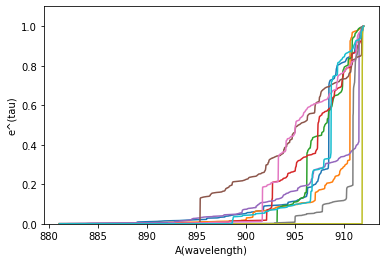

In [68]:
ax1 = plt.subplot()
for i in range(10):
    raw_path = 'los.00' + '{0:03}'.format(i+number) +'.raw'
    distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
    distance_redshift = change_to_redshift(distance, 6.37)
    wavelength = change_to_wavelength(distance_redshift,6.37)
    ax1.plot(wavelength[3:],np.power(np.e,np.multiply(-1,mfp[i])))
    ax1.set_xlabel("A(wavelength)")
    ax1.set_ylabel("e^(tau)")
    ax1.set_ylim(0,1.1)

In [69]:

y = []
for i in range(10):
    for z in mfp[i]:
        y.append(z)
x = []
for i in range(10):
    raw_path = 'los.00' + '{0:03}'.format(i+number) +'.raw'
    distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
    distance_redshift = change_to_redshift(distance,6.37)
    wavelength = change_to_wavelength(distance_redshift,6.37)
    for p in wavelength[3:]:
        x.append(p)

In [70]:
print(len(x))

57083


In [71]:
z = np.polyfit(x, np.power(np.e,np.multiply(-1,y)), 4)

In [72]:
yn = np.poly1d(z)
yn(906)

0.2253801072947681

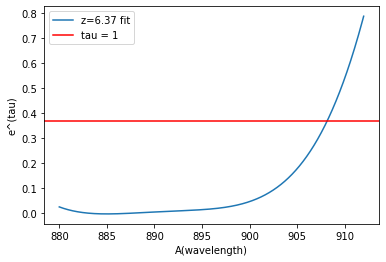

In [73]:
x_fit = np.linspace(880,912,1000)
plt.plot(x_fit,yn(x_fit),label = 'z=6.37 fit')
plt.axhline(y=0.367879, color='r', linestyle='-',label ="tau = 1")
plt.xlabel("A(wavelength)")
plt.ylabel("e^(tau)")
plt.legend()

In [74]:
with open('yn_30_40.pkl', 'wb') as f:
    pickle.dump(yn, f, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
with open('yn_0_10.pkl','rb') as f:
    yn = pickle.load(f)
with open('yn_10_20.pkl','rb') as f:
    yn_1 = pickle.load(f)
with open('yn_20_30.pkl','rb') as f:
    yn_2 = pickle.load(f)
with open('yn_30_40.pkl','rb') as f:
    yn_3 = pickle.load(f)

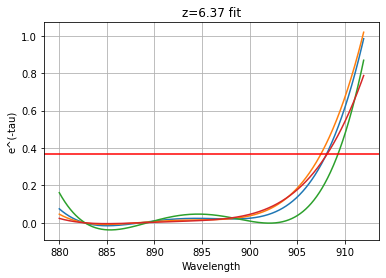

In [83]:
plt.plot(x_fit,yn(x_fit))
plt.plot(x_fit,yn_1(x_fit))
plt.plot(x_fit,yn_2(x_fit))
plt.plot(x_fit,yn_3(x_fit))
plt.title("z=6.37 fit")
plt.axhline(y=0.367879, color='r', linestyle='-',label ="tau = 1")
plt.xlabel("Wavelength")
plt.ylabel("e^(-tau)")
plt.grid()